In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import json
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from gaminet import GAMINetClassifier
from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

In [2]:
def load_fico(path="./", missing_strategy="drop"):
    data = pd.read_csv(path + "/fico/heloc_dataset_v1.csv")
    meta_info = json.load(open(path + "/fico/data_types.json"))
    meta_info.pop("RiskPerformance")

    ## remove samples with all the values == -9
    rem_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) == 23)[0]
    keep_sample_idx = np.where(np.sum(data.values[:, 1:].astype(float) == -9, 1) < 23)[0]
    data_rem9 = data.iloc[keep_sample_idx]

    ## dummy for -7, -8, -9
    sample_size = data_rem9.shape[0]
    dummy_data = pd.DataFrame(index = data_rem9.index)
    for i in np.where(np.sum(data_rem9 == -9, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -9)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-9"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-9":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -8, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -8)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-8"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-8":{"type": "categorical"}})

    for i in np.where(np.sum(data_rem9 == -7, 0).values > 0)[0]:
        temp = np.zeros(sample_size)
        temp[np.where(data_rem9.iloc[:, i].values == -7)[0]] = 1
        dummy_data[data_rem9.columns[i] + "_D-7"] = temp
        meta_info.update({data_rem9.columns[i] + "_D-7":{"type": "categorical"}})

    meta_info.update({"RiskPerformance":{"type": "target"}})
    final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)
    x, y = final_data.iloc[:,1:].values, final_data.iloc[:,[0]].values
    return x, y, "Classification", meta_info

def load_classification_data(name):
    data_path = '.'
    func_dict = {'fico':load_fico}
    def wrapper(random_state):
        function_name_ = func_dict[name]
        x, y, task_type, meta_info = function_name_(data_path, missing_strategy="impute")
        xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
        for i, (key, item) in enumerate(meta_info.items()):
            if item['type'] == 'target':
                enc = OrdinalEncoder()
                enc.fit(y)
                y = enc.transform(y)
                meta_info[key]['values'] = enc.categories_[0].tolist()
            elif item['type'] == 'categorical':
                enc = OrdinalEncoder()
                xx[:,[i]] = enc.fit_transform(x[:,[i]])
                meta_info[key]['values'] = []
                for item in enc.categories_[0].tolist():
                    try:
                        if item == int(item):
                            meta_info[key]['values'].append(str(int(item)))
                        else:
                            meta_info[key]['values'].append(str(item))
                    except ValueError:
                        meta_info[key]['values'].append(str(item))
            else:
                sx = MinMaxScaler((0, 1))
                xx[:,[i]] = sx.fit_transform(x[:,[i]])
                meta_info[key]['scaler'] = sx
        train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, stratify=y,
                                                            test_size=0.2, random_state=random_state)
        return train_x, test_x, train_y, test_y, task_type, meta_info
    return wrapper

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

In [4]:
random_state = 0
data_loader = load_classification_data("fico")
train_x, test_x, train_y, test_y, task_type, meta_info = data_loader(random_state)

/tmp/ipykernel_1812920/755819285.py:33: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  final_data = pd.concat([data_rem9.replace(-9, 0).replace(-8, 0).replace(-7, 0), dummy_data], 1)


In [5]:
meta_info.keys()

dict_keys(['ExternalRiskEstimate', 'MSinceOldestTradeOpen', 'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades', 'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec', 'PercentTradesNeverDelq', 'MSinceMostRecentDelq', 'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades', 'NumTradesOpeninLast12M', 'PercentInstallTrades', 'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days', 'NetFractionRevolvingBurden', 'NetFractionInstallBurden', 'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance', 'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance', 'ExternalRiskEstimate_D-9', 'MSinceOldestTradeOpen_D-8', 'MSinceMostRecentDelq_D-8', 'MSinceMostRecentInqexcl7days_D-8', 'NetFractionRevolvingBurden_D-8', 'NetFractionInstallBurden_D-8', 'NumRevolvingTradesWBalance_D-8', 'NumInstallTradesWBalance_D-8', 'NumBank2NatlTradesWHighUtilization_D-8', 'PercentTradesWBalance_D-8', 'MSinceMostRecentDelq_D-7', 'MSinceMostRecentInqexcl7days_D-7', 'Risk

In [6]:
model = GAMINetClassifier(interact_num=10,
                          subnet_size_main_effect=(20, ),
                          subnet_size_interaction=(20, 20), 
                          max_epochs=(1000, 1000, 1000),
                          learning_rates=(0.001, 0.001, 0.0001),
                          early_stop_thres=("auto", "auto", "auto"),
                          batch_size=1000,
                          warm_start=False,
                          reg_clarity=0.1,
                          reg_mono=1,
                          mono_sample_size=1000,
                          mono_increasing_list=(0, 1, 2, 3, 4, 7, 8, 9, 10, 14),
                          mono_decreasing_list=(5, 6, 12, 15, 16, 17, 18, 21),
                          verbose=True,
                          random_state=random_state)
model.fit(train_x, train_y)

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 0.62634, validation loss: 0.60333: 100%|██████████| 7/7 [00:00<00:00, 14.32it/s]                          
Epoch:    2, train loss: 0.59697, validation loss: 0.58226: 100%|██████████| 7/7 [00:00<00:00, 50.47it/s]                          
Epoch:    3, train loss: 0.57855, validation loss: 0.56896: 100%|██████████| 7/7 [00:00<00:00, 50.45it/s]                          
Epoch:    4, train loss: 0.56594, validation loss: 0.56036: 100%|██████████| 7/7 [00:00<00:00, 52.18it/s]                          
Epoch:    5, train loss: 0.55745, validation loss: 0.55540: 100%|██████████| 7/7 [00:00<00:00, 51.11it/s]                          
Epoch:    6, train loss: 0.55166, validation loss: 0.55254: 100%|██████████| 7/7 [00:00<00:00, 49.20it/s]                          
Epoch:    7, train loss: 0.54777, validation loss: 0.55019: 100%|██████████| 7/7 [00:00<00:00, 51.84it/s]                          
Epoch:    8, train loss: 0.54542, validation loss: 0.54890: 100%|██████████|

Epoch:   63, train loss: 0.52832, validation loss: 0.53399: 100%|██████████| 7/7 [00:00<00:00, 51.54it/s]                          
Epoch:   64, train loss: 0.52878, validation loss: 0.53407: 100%|██████████| 7/7 [00:00<00:00, 51.54it/s]                          
Epoch:   65, train loss: 0.52845, validation loss: 0.53361: 100%|██████████| 7/7 [00:00<00:00, 50.96it/s]                          
Epoch:   66, train loss: 0.52919, validation loss: 0.53400: 100%|██████████| 7/7 [00:00<00:00, 53.78it/s]                          
Epoch:   67, train loss: 0.52839, validation loss: 0.53399: 100%|██████████| 7/7 [00:00<00:00, 53.22it/s]                          
Epoch:   68, train loss: 0.52877, validation loss: 0.53384: 100%|██████████| 7/7 [00:00<00:00, 52.17it/s]                          
Epoch:   69, train loss: 0.52871, validation loss: 0.53371: 100%|██████████| 7/7 [00:00<00:00, 54.30it/s]                          
Epoch:   70, train loss: 0.52791, validation loss: 0.53434: 100%|██████████|

Epoch:  125, train loss: 0.52872, validation loss: 0.53636: 100%|██████████| 7/7 [00:00<00:00, 47.07it/s]                          
Epoch:  126, train loss: 0.52854, validation loss: 0.53731: 100%|██████████| 7/7 [00:00<00:00, 45.78it/s]                          
Epoch:  127, train loss: 0.52885, validation loss: 0.53696: 100%|██████████| 7/7 [00:00<00:00, 44.66it/s]                          
Epoch:  128, train loss: 0.52877, validation loss: 0.53731: 100%|██████████| 7/7 [00:00<00:00, 48.72it/s]                          
Epoch:  129, train loss: 0.52878, validation loss: 0.53752: 100%|██████████| 7/7 [00:00<00:00, 50.19it/s]                          
Epoch:  130, train loss: 0.52873, validation loss: 0.53773: 100%|██████████| 7/7 [00:00<00:00, 47.82it/s]                          
Epoch:  131, train loss: 0.52880, validation loss: 0.53826: 100%|██████████| 7/7 [00:00<00:00, 50.08it/s]                          
Epoch:  132, train loss: 0.52955, validation loss: 0.53876: 100%|██████████|

Main Effect Training Stop at Epoch: 133, train loss: 0.52905, validation loss: 0.53888
####################Stage 2: Interaction Training####################


Epoch:    1, train loss: 0.53856, validation loss: 0.54135: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s]                          
Epoch:    2, train loss: 0.53644, validation loss: 0.54538: 100%|██████████| 7/7 [00:00<00:00, 19.63it/s]                          
Epoch:    3, train loss: 0.53919, validation loss: 0.54737: 100%|██████████| 7/7 [00:00<00:00, 19.37it/s]                          
Epoch:    4, train loss: 0.53918, validation loss: 0.54726: 100%|██████████| 7/7 [00:00<00:00, 19.90it/s]                          
Epoch:    5, train loss: 0.53795, validation loss: 0.54666: 100%|██████████| 7/7 [00:00<00:00, 18.84it/s]                          
Epoch:    6, train loss: 0.53677, validation loss: 0.54656: 100%|██████████| 7/7 [00:00<00:00, 18.61it/s]                          
Epoch:    7, train loss: 0.53611, validation loss: 0.54679: 100%|██████████| 7/7 [00:00<00:00, 18.72it/s]                          
Epoch:    8, train loss: 0.53597, validation loss: 0.54710: 100%|██████████|

Interaction Training Stop at Epoch: 53, train loss: 0.53777, validation loss: 0.55351
#########################Stage 3: Fine Tuning#########################


Epoch:    1, train loss: 0.52886, validation loss: 0.53782: 100%|██████████| 7/7 [00:00<00:00, 20.96it/s]                          
Epoch:    2, train loss: 0.52866, validation loss: 0.53754: 100%|██████████| 7/7 [00:00<00:00, 20.50it/s]                          
Epoch:    3, train loss: 0.52854, validation loss: 0.53739: 100%|██████████| 7/7 [00:00<00:00, 20.13it/s]                          
Epoch:    4, train loss: 0.52844, validation loss: 0.53730: 100%|██████████| 7/7 [00:00<00:00, 20.59it/s]                          
Epoch:    5, train loss: 0.52833, validation loss: 0.53720: 100%|██████████| 7/7 [00:00<00:00, 20.50it/s]                          
Epoch:    6, train loss: 0.52826, validation loss: 0.53711: 100%|██████████| 7/7 [00:00<00:00, 21.30it/s]                          
Epoch:    7, train loss: 0.52820, validation loss: 0.53701: 100%|██████████| 7/7 [00:00<00:00, 21.12it/s]                          
Epoch:    8, train loss: 0.52814, validation loss: 0.53692: 100%|██████████|

Epoch:   63, train loss: 0.52675, validation loss: 0.53490: 100%|██████████| 7/7 [00:00<00:00, 20.78it/s]                          
Epoch:   64, train loss: 0.52675, validation loss: 0.53491: 100%|██████████| 7/7 [00:00<00:00, 20.85it/s]                          
Epoch:   65, train loss: 0.52674, validation loss: 0.53491: 100%|██████████| 7/7 [00:00<00:00, 20.73it/s]                          
Epoch:   66, train loss: 0.52671, validation loss: 0.53490: 100%|██████████| 7/7 [00:00<00:00, 20.18it/s]                          
Epoch:   67, train loss: 0.52672, validation loss: 0.53486: 100%|██████████| 7/7 [00:00<00:00, 20.03it/s]                          
Epoch:   68, train loss: 0.52672, validation loss: 0.53482: 100%|██████████| 7/7 [00:00<00:00, 21.05it/s]                          
Epoch:   69, train loss: 0.52672, validation loss: 0.53483: 100%|██████████| 7/7 [00:00<00:00, 20.66it/s]                          
Epoch:   70, train loss: 0.52669, validation loss: 0.53482: 100%|██████████|

Epoch:  125, train loss: 0.52633, validation loss: 0.53448: 100%|██████████| 7/7 [00:00<00:00, 21.47it/s]                          
Epoch:  126, train loss: 0.52633, validation loss: 0.53445: 100%|██████████| 7/7 [00:00<00:00, 21.09it/s]                          
Epoch:  127, train loss: 0.52633, validation loss: 0.53446: 100%|██████████| 7/7 [00:00<00:00, 21.45it/s]                          
Epoch:  128, train loss: 0.52633, validation loss: 0.53446: 100%|██████████| 7/7 [00:00<00:00, 21.11it/s]                          
Epoch:  129, train loss: 0.52633, validation loss: 0.53446: 100%|██████████| 7/7 [00:00<00:00, 20.81it/s]                          
Epoch:  130, train loss: 0.52631, validation loss: 0.53444: 100%|██████████| 7/7 [00:00<00:00, 20.80it/s]                          
Epoch:  131, train loss: 0.52635, validation loss: 0.53440: 100%|██████████| 7/7 [00:00<00:00, 20.51it/s]                          
Epoch:  132, train loss: 0.52631, validation loss: 0.53442: 100%|██████████|

Fine Tuning Stop at Epoch: 163, train loss: 0.52622, validation loss: 0.53441


GAMINetClassifier(batch_size=1000,
                  mono_decreasing_list=(5, 6, 12, 15, 16, 17, 18, 21),
                  mono_increasing_list=(0, 1, 2, 3, 4, 7, 8, 9, 10, 14),
                  reg_mono=81140.42066856, verbose=True, warm_start=False)

In [7]:
pred_train = model.predict_proba(train_x)[:, 1]
pred_test = model.predict_proba(test_x)[:, 1]
gaminet_stat = np.hstack([np.round(get_metric(train_y, pred_train.ravel()),5),
                          np.round(get_metric(test_y, pred_test.ravel()),5)])
print(gaminet_stat)

[0.8148  0.80886]


In [8]:
gaminet_stat = np.hstack([np.round(np.mean(train_y.ravel() == (pred_train > 0.5).ravel()),5),
                          np.round(np.mean(test_y.ravel() == (pred_test > 0.5).ravel()),5)])
print(gaminet_stat)

[0.74607 0.73975]


In [9]:
model.certify_mono()

True

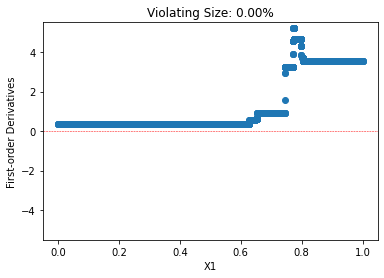

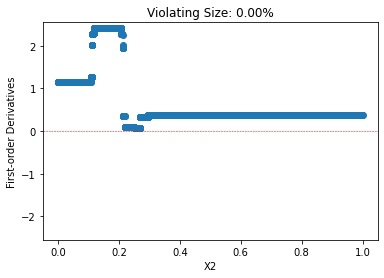

/root/zebin/projects/GAMINet_Pytorch/examples/../gaminet/base.py:1619: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.
  plt.ylim(-absmax, absmax)


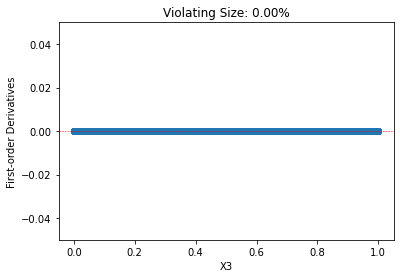

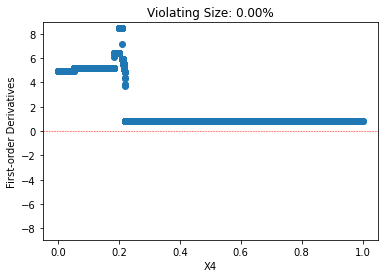

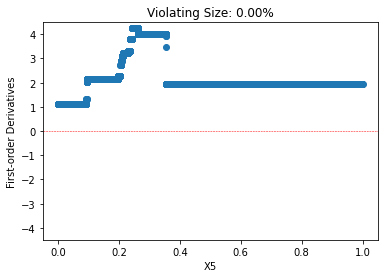

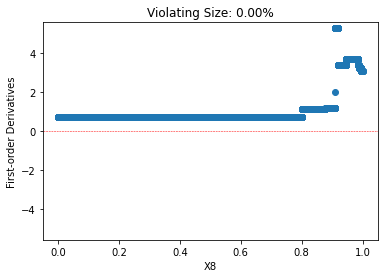

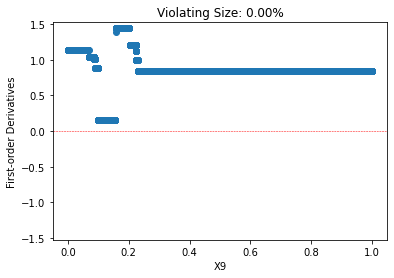

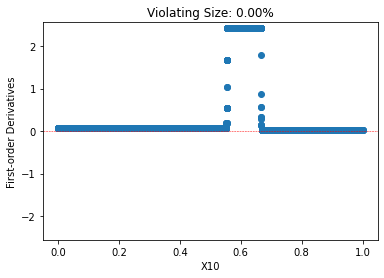

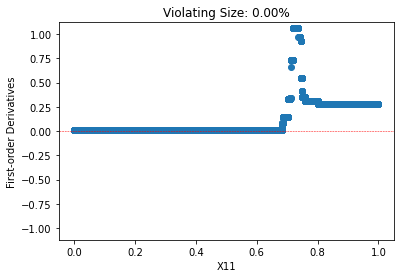

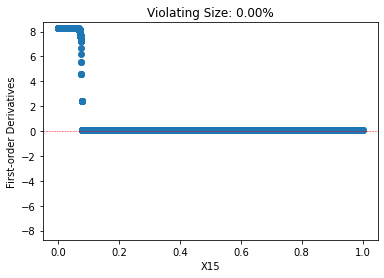

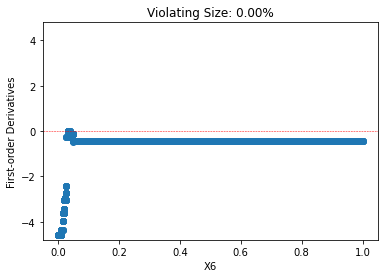

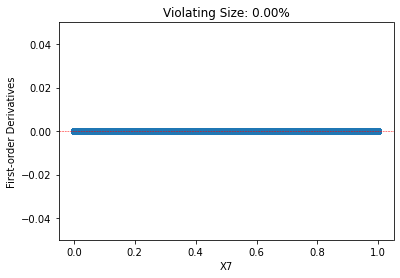

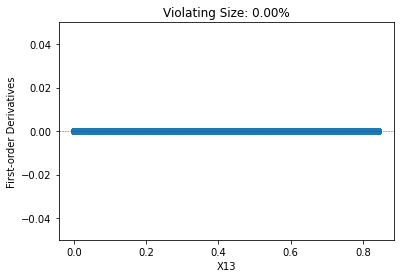

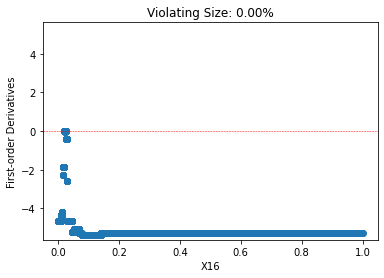

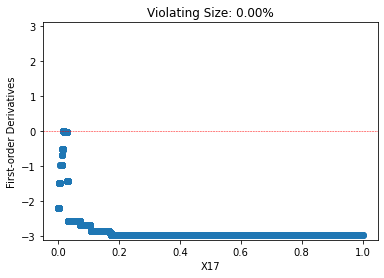

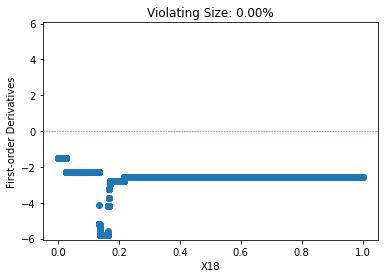

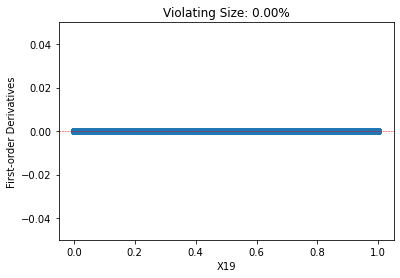

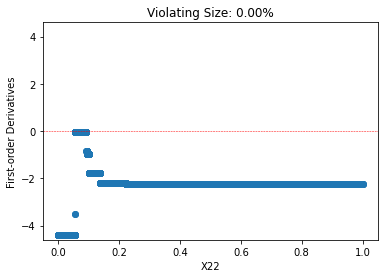

In [10]:
for i in model.mono_increasing_list + model.mono_decreasing_list:
    model.partial_derivatives(i)

## Visualization

### Training details

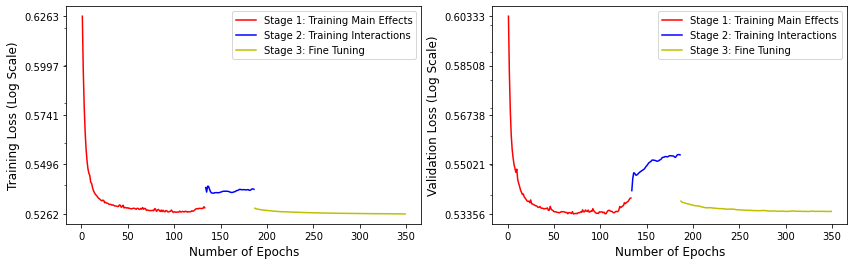

In [11]:
model.show_loss_trajectory()

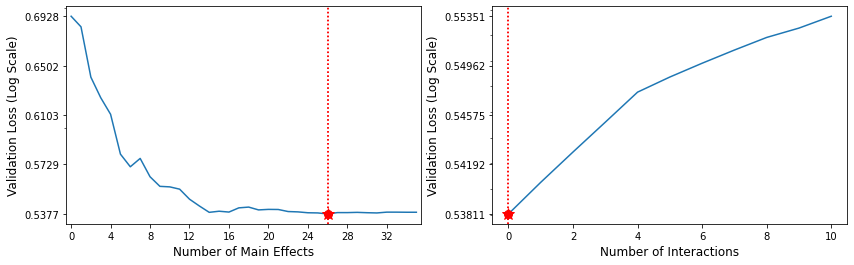

In [12]:
model.show_regularization_path()

### Global explaination

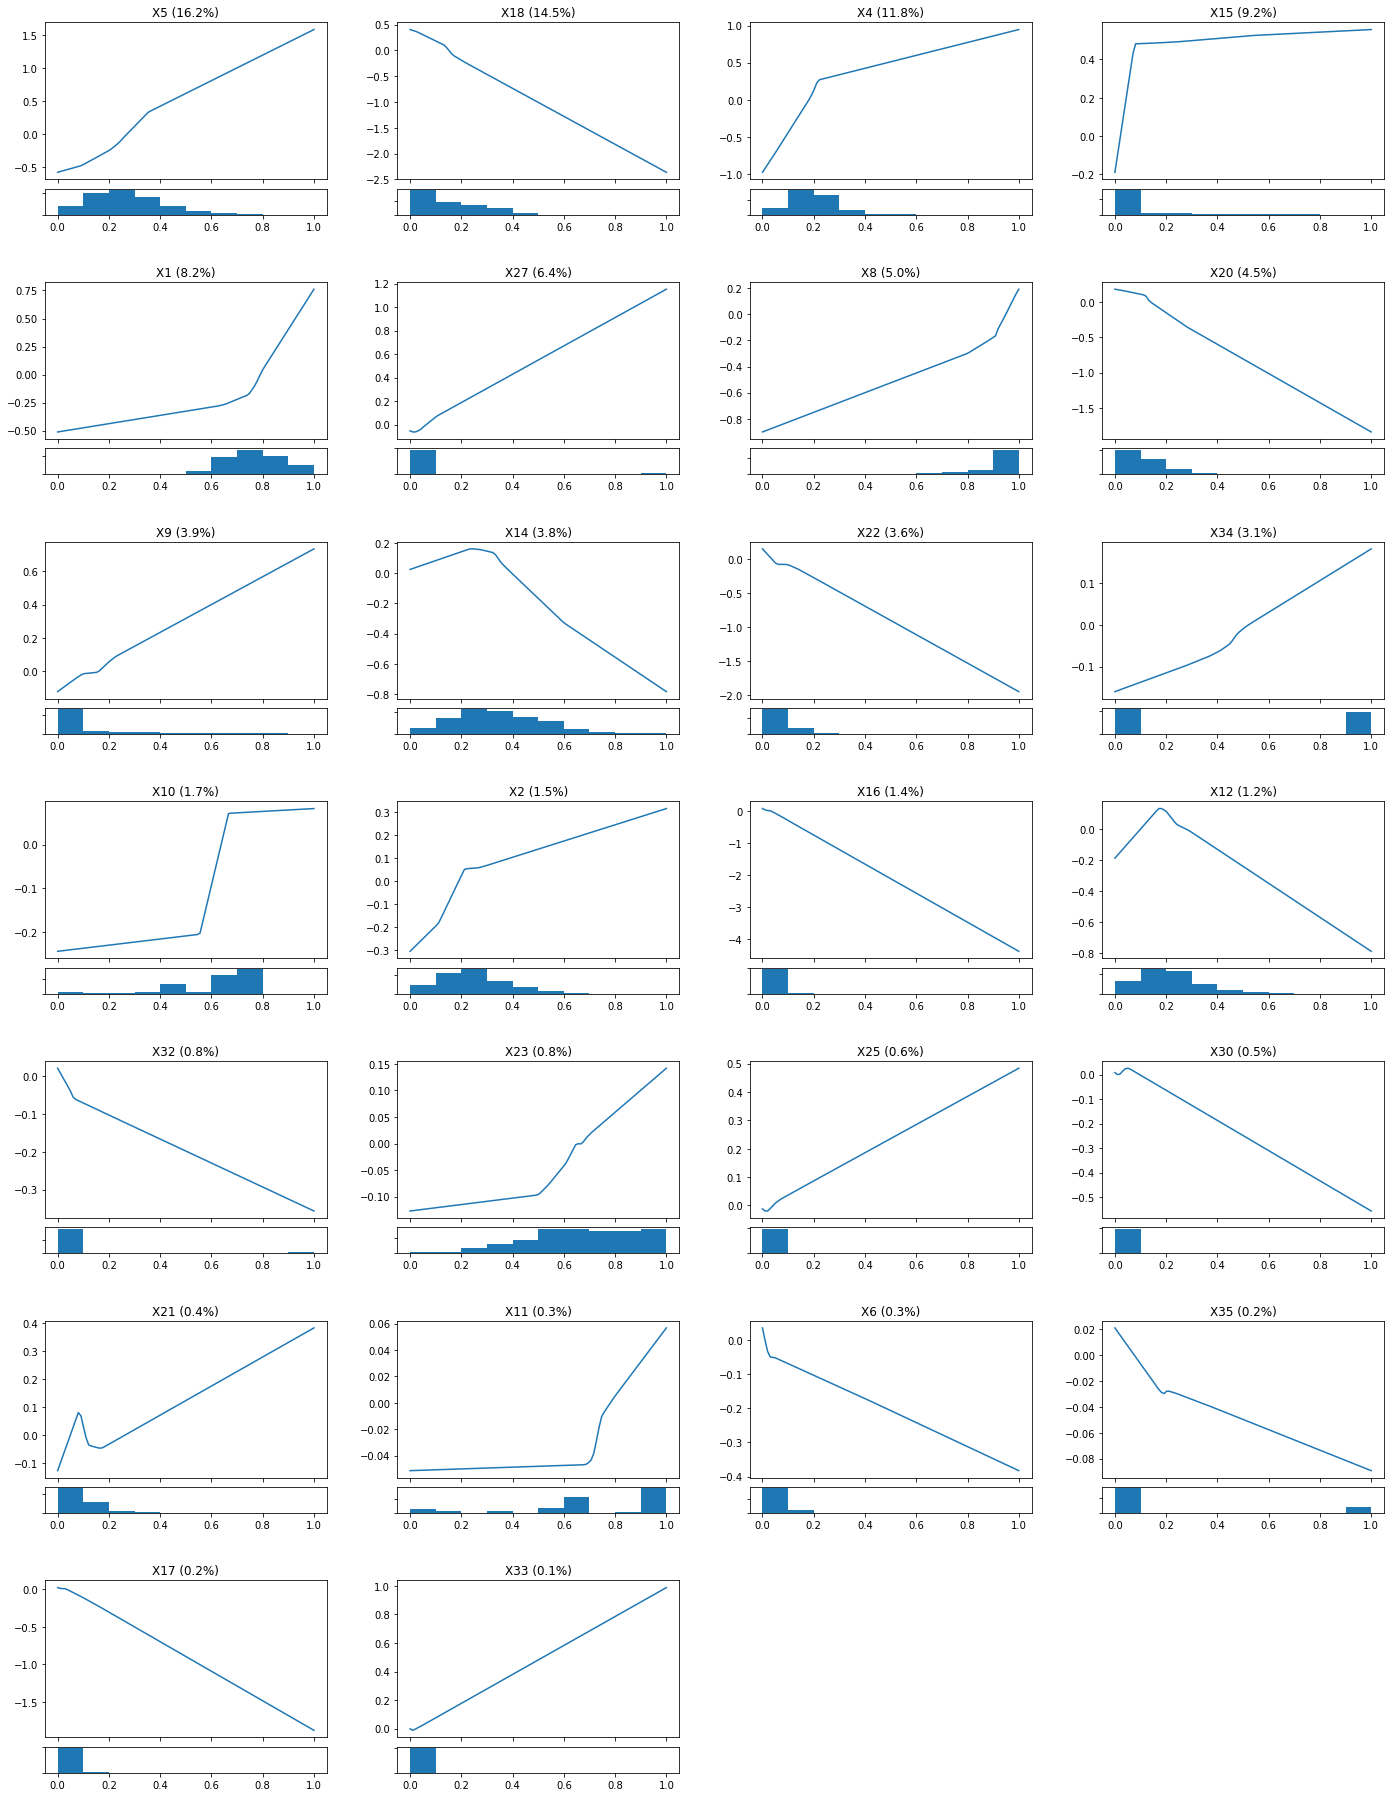

In [13]:
# show all effects 
model.show_global_explain()

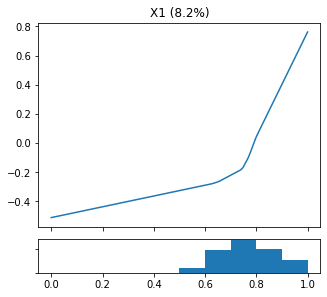

In [14]:
# show one specific effect
model.show_global_explain(key="X1")

### Feature and effect importance

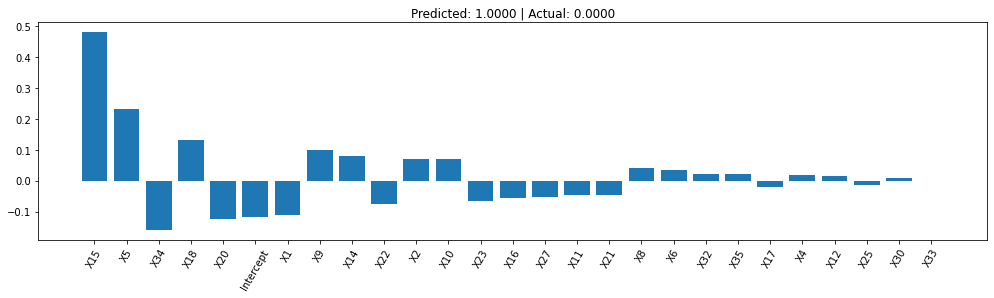

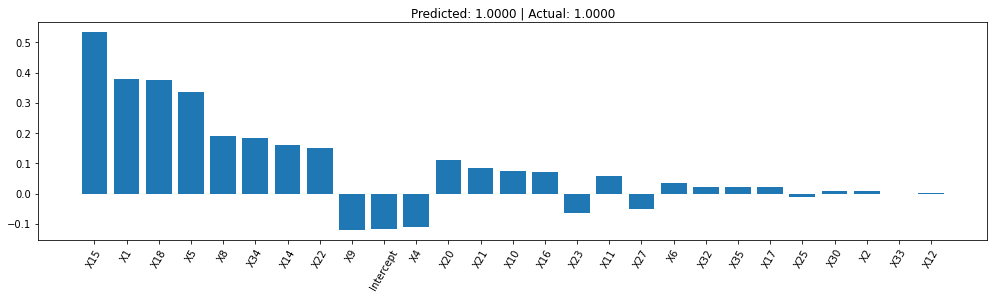

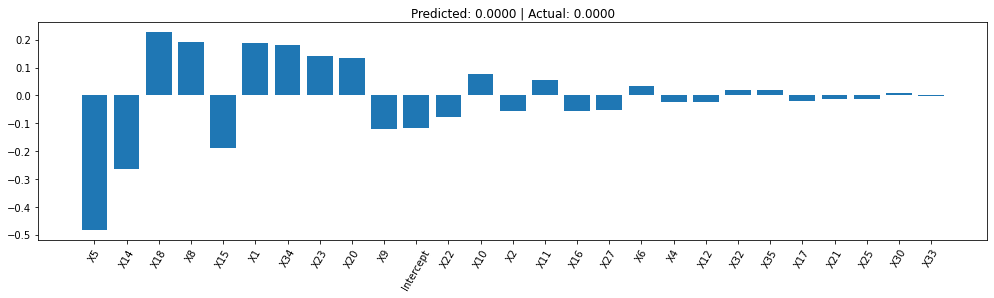

In [15]:
model.show_local_explain(train_x[:3], train_y[:3])

### Local Explain

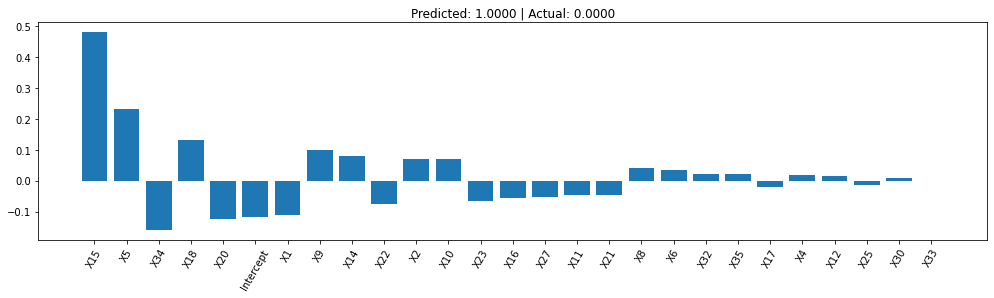

In [16]:
## explain single sample 
model.show_local_explain(train_x[[0]], train_y[[0]])

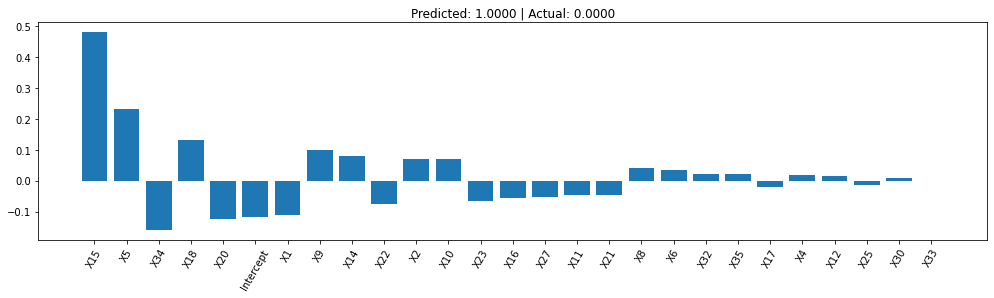

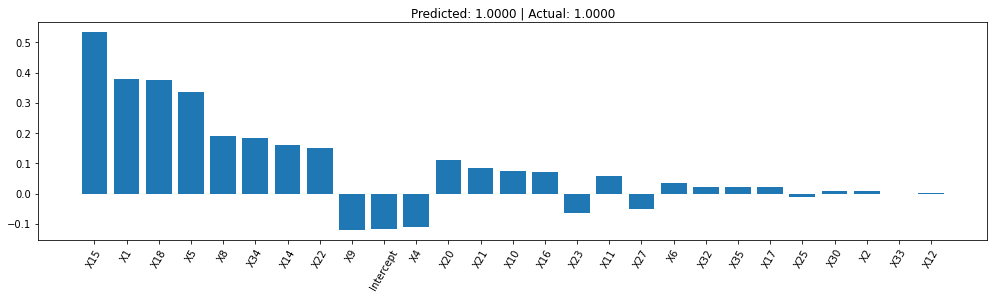

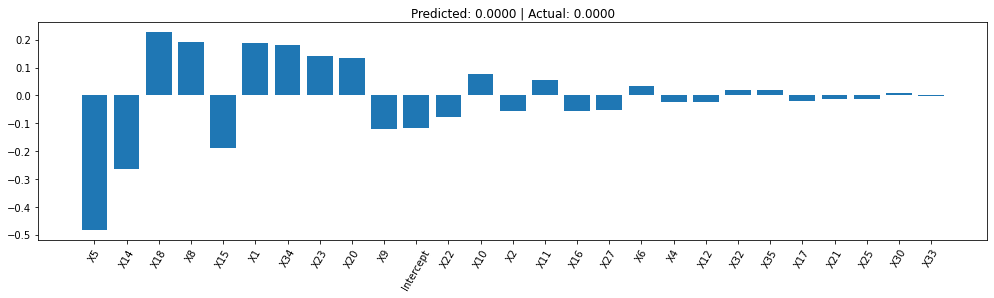

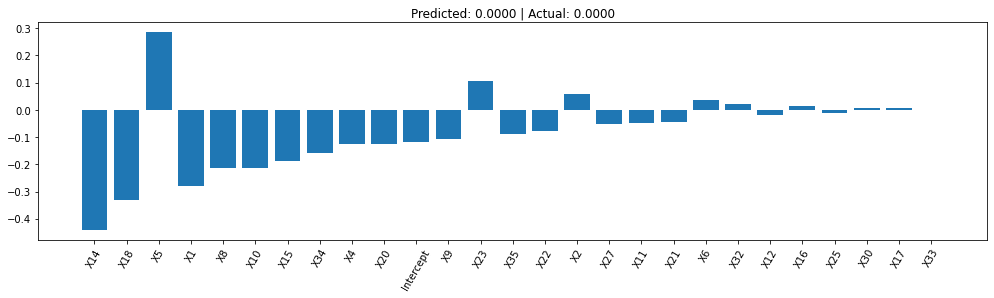

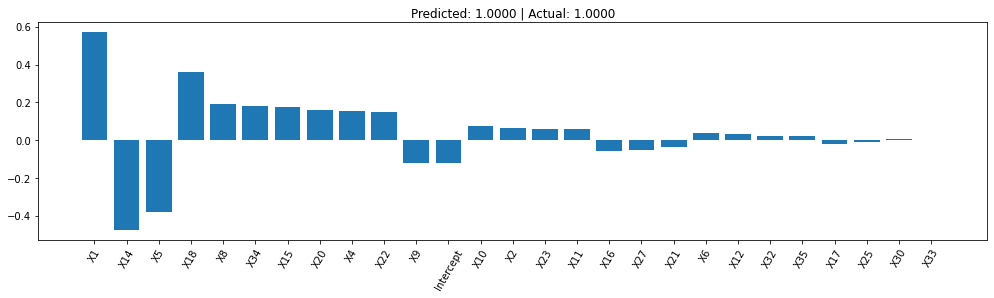

In [17]:
# explain multiple samples
data_dict_local = model.local_explain(train_x[:5], train_y[:5])
for i in range(len(data_dict_local)):
    local_visualize(data_dict_local[i])